In [263]:
import matplotlib.pyplot as plt
from census_area import Census
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns

%matplotlib inline

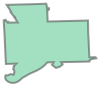

In [336]:
# Defines the territory of ithaca

citybounds = gpd.read_file("citybounds/TCMuni2010.shp")
citybounds = citybounds.to_crs({'init': 'epsg:4269'})
ithaca = citybounds[citybounds.FULLNAME == "CITY OF ITHACA"].iloc[0]['geometry']
ithaca

In [623]:
# Imports data on the roads of ithaca
full_roads = gpd.read_file("TcRoads/TcRoads.shp")
roads = full_roads[full_roads.intersects(ithaca)]

### Census block data
We gather data from each census block about it's shape and area.

In [326]:
full_block_data = gpd.read_file("ny_blocks/tl_2019_36_tabblock10.shp")

In [337]:
block_data = full_block_data.copy()

block_data = block_data[block_data.geometry.intersects(ithaca)]

block_data.set_index(["TRACTCE10", "BLOCKCE10"], inplace=True)
block_data = block_data[["ALAND10", "INTPTLAT10", "INTPTLON10", "geometry"]]
block_data.rename(
    columns = {"ALAND10": "land_area", "INTPTLAT10": "lat",
               "INTPTLON10": "lon", "geometry":"geometry"},
    inplace = True)
block_data.rename_axis(
    index = {"TRACTCE10": "tract", "BLOCKCE10": "block"},
    inplace = True)
block_data.head()

,,land_area,lat,lon,geometry
tract,block,,,,
000800,1021,11815,+42.4427521,-076.5092441,"POLYGON ((-76.50998 42.44318, -76.50988 42.443..."
000600,4050,958,+42.4627239,-076.5005348,"POLYGON ((-76.50074 42.46274, -76.50073 42.462..."
000100,1027,11104,+42.4391552,-076.4961135,"POLYGON ((-76.49681 42.43961, -76.49562 42.439..."
000600,4095,0,+42.4529128,-076.4920604,"POLYGON ((-76.49468 42.45329, -76.49444 42.453..."
001100,2007,20225,+42.4353741,-076.4934568,"POLYGON ((-76.49468 42.43580, -76.49231 42.435..."


Additionally, we gather data on the population of each census block (this is from the 2010 census).

In [342]:
pop_data = pd.read_csv("populations.csv", skiprows=[1])
pop_data["tract"]  = [x[14:20] for x in pop_data.GEO_ID]
pop_data["block"]  = [x[20:] for x in pop_data.GEO_ID]

pop_data.set_index(["tract", "block"], inplace=True)

del pop_data["GEO_ID"], pop_data["NAME"]
pop_data.columns = ["population"]
pop_data.head()

,,population
tract,block,
001600,1101,41
001800,1025,0
001900,4010,17
002300,2061,22
001100,1005,0


In [343]:
if "population" not in block_data.columns:
  block_data = block_data.merge(pop_data, "left", left_index = True, right_index=True)
block_data["pop_density"] = (block_data.population / block_data.land_area).fillna(value=0)
block_data.head()

,,land_area,lat,lon,geometry,population,pop_density
tract,block,,,,,,
000800,1021,11815,+42.4427521,-076.5092441,"POLYGON ((-76.50998 42.44318, -76.50988 42.443...",6,0.000508
000600,4050,958,+42.4627239,-076.5005348,"POLYGON ((-76.50074 42.46274, -76.50073 42.462...",0,0.000000
000100,1027,11104,+42.4391552,-076.4961135,"POLYGON ((-76.49681 42.43961, -76.49562 42.439...",0,0.000000
000600,4095,0,+42.4529128,-076.4920604,"POLYGON ((-76.49468 42.45329, -76.49444 42.453...",0,0.000000
001100,2007,20225,+42.4353741,-076.4934568,"POLYGON ((-76.49468 42.43580, -76.49231 42.435...",101,0.004994


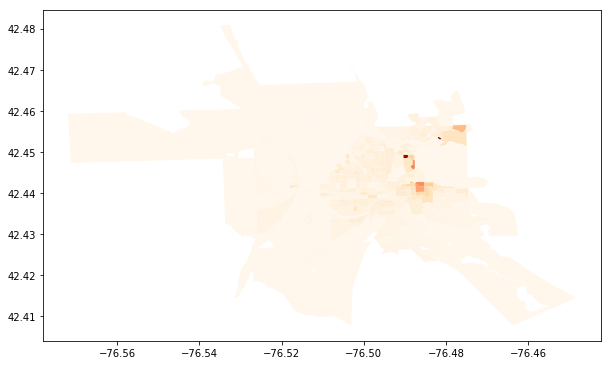

In [344]:
fig, ax = plt.subplots(figsize=(10,10))

block_data.plot(column="pop_density", ax = ax, cmap='OrRd')

In [345]:
working_data = gpd.read_file("worker_data/C33.shp")

In [346]:
working_data['working_density'] = working_data.F1 / working_data.to_crs({'proj':'cea'}).area
working_data.head()

,ctpp_id,label,name,geoid,F1,F2,geometry,working_density
0,C3300US3610900000235,3610900000235,"TAZ 00000235, Tompkins County, New York",3610900000235,40.0,34.0,"POLYGON ((-76.54610 42.47077, -76.54598 42.470...",0.000008
1,C3300US3610900000199,3610900000199,"TAZ 00000199, Tompkins County, New York",3610900000199,110.0,72.0,"POLYGON ((-76.54654 42.46745, -76.54483 42.467...",0.000082
2,C3300US3610900000317,3610900000317,"TAZ 00000317, Tompkins County, New York",3610900000317,180.0,70.0,"POLYGON ((-76.49703 42.44389, -76.49702 42.443...",0.002747
3,C3300US3610900000321,3610900000321,"TAZ 00000321, Tompkins County, New York",3610900000321,740.0,186.0,"POLYGON ((-76.50609 42.43841, -76.50613 42.439...",0.006827
4,C3300US3610900000283,3610900000283,"TAZ 00000283, Tompkins County, New York",3610900000283,155.0,81.0,"POLYGON ((-76.50671 42.44839, -76.50647 42.448...",0.003017


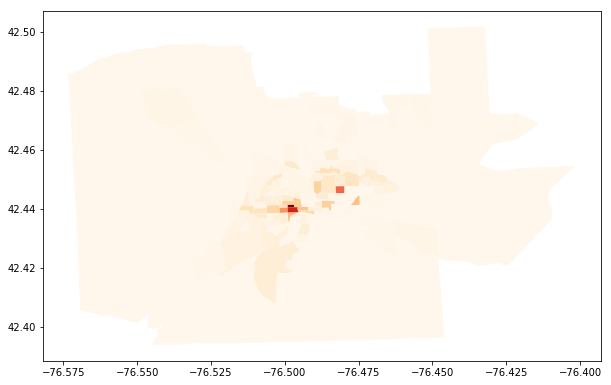

In [347]:
fig, ax = plt.subplots(figsize=(10,10))

working_data.plot(column="working_density", ax=ax, cmap='OrRd')

In [349]:
combined = gpd.overlay(block_data, working_data, how='intersection')
combined.head()

,land_area,lat,lon,population,pop_density,ctpp_id,label,name,geoid,F1,F2,working_density,geometry
0,11815,+42.4427521,-076.5092441,6,0.000508,C3300US3610900000325,3610900000325,"TAZ 00000325, Tompkins County, New York",3610900000325,50.0,43.0,0.000598,"POLYGON ((-76.50850 42.44232, -76.50850 42.442..."
1,10062,+42.4404802,-076.5112254,2,0.000199,C3300US3610900000325,3610900000325,"TAZ 00000325, Tompkins County, New York",3610900000325,50.0,43.0,0.000598,"POLYGON ((-76.51065 42.44095, -76.51065 42.440..."
2,18439,+42.4406050,-076.5073046,54,0.002929,C3300US3610900000325,3610900000325,"TAZ 00000325, Tompkins County, New York",3610900000325,50.0,43.0,0.000598,"POLYGON ((-76.50843 42.44102, -76.50672 42.441..."
3,26363,+42.4416392,-076.5095748,84,0.003186,C3300US3610900000325,3610900000325,"TAZ 00000325, Tompkins County, New York",3610900000325,50.0,43.0,0.000598,"POLYGON ((-76.51071 42.44226, -76.51004 42.442..."
4,14269,+42.4428006,-076.5076678,34,0.002383,C3300US3610900000325,3610900000325,"TAZ 00000325, Tompkins County, New York",3610900000325,50.0,43.0,0.000598,"POLYGON ((-76.50678 42.44237, -76.50678 42.442..."


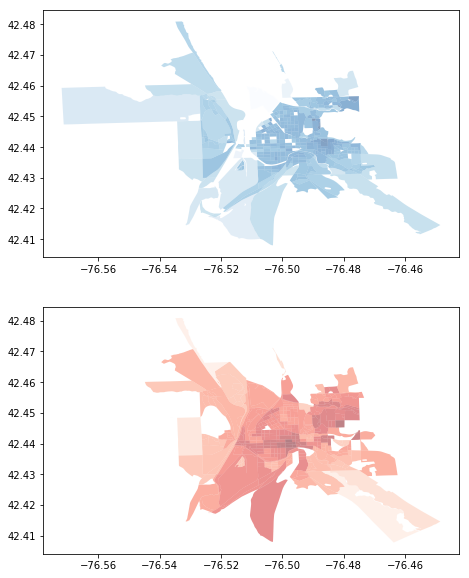

In [376]:
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(2, figsize=(10, 10))

def non_zero_min(s):
  return min(s[s > 0])

combined.plot(column="pop_density", cmap='Blues', ax=axs[0],
              norm=LogNorm(non_zero_min(combined.pop_density), combined.pop_density.max()),
             alpha =.5)
combined.plot(column="working_density", cmap='Reds', ax=axs[1],
             norm=LogNorm(non_zero_min(combined.working_density), combined.working_density.max()),
             alpha =.5)

In [629]:
full_parcel_data = gpd.read_file("Parcels_2019/Parcels_2019.shp")
full_parcel_data.columns

Index(['FID', 'PARCELKEY', 'SWISPRINTK', 'SWIS', 'PRINTKEY', 'MUNI',
       'CALCACRES', 'MODIFIED', 'TAXMAP', 'SBL', 'TAXID', 'MAILING',
       'MAIL_1ADDR', 'MAIL_2ADDR', 'MAIL_CITY', 'MAIL_STATE', 'MAIL_ZIP',
       'LAND', 'ASMT', 'SCHOOL', 'SCHDIST', 'LOC', 'LOCATION', 'LOCADDR',
       'LOCZIP', 'AGDIST', 'NEIGHB', 'ZONING', 'ROLLSECT', 'RS', 'BOOK',
       'PAGE', 'FRONTAGE', 'DEPTH', 'ACRES', 'PC', 'PROPCLASS', 'DESCRIPTIO',
       'GREAST', 'GRNORTH', 'WATER', 'SEWER', 'IMATELINK', 'IMATESTAFF',
       'ROLLYEAR', 'PARYEAR', 'SALE_DATE', 'SALE_PRICE', 'SQ_FT', 'YR_BUILT',
       'STORIES', 'GISNOTES', 'Shape_Leng', 'Shape_Area', 'Ags', 'Shape__Are',
       'Shape__Len', 'geometry'],
      dtype='object')

In [363]:
parcel_data = full_parcel_data[['MUNI', 'TAXMAP', 'ZONING', 'PROPCLASS', 'SQ_FT', 'DESCRIPTIO', 'geometry']]
parcel_data = parcel_data[parcel_data.MUNI=="Ithaca"]
parcel_data.to_crs({'init': 'epsg:4269'}, inplace=True)
parcel_data['geometry'] = parcel_data.geometry.centroid
parcel_data = parcel_data[parcel_data['geometry'].intersects(ithaca)]
print(len(parcel_data))
parcel_data.head()

5452


,MUNI,TAXMAP,ZONING,PROPCLASS,SQ_FT,DESCRIPTIO,geometry
0,Ithaca,58,WF-1a,Vacant,20174,Com vac w/imp,POINT (-76.51225 42.44231)
1,Ithaca,58,WF-1c,Commercial,2380,1 use sm bld,POINT (-76.51224 42.44201)
2,Ithaca,58,WF-1c,Commercial,2609,Restaurant,POINT (-76.51224 42.44186)
3,Ithaca,58,WF-1c,Commercial,3024,1 use sm bld,POINT (-76.51224 42.44168)
4,Ithaca,50,R-2b,Residential,1782,1 Family Res,POINT (-76.50280 42.44427)


In [674]:
def get_category(category, parcels):
  reqs = {
    'housing': [("PROPCLASS", 'Residential'),
                ('DESCRIPTIO', 'Apartment')],
    'office': [('DESCRIPTIO', 'Office bldg.'),
               ('DESCRIPTIO', 'Prof. bldg.'),
               ('DESCRIPTIO', 'Auto body'),
               ('DESCRIPTIO', '1 use sm bld')],
    'school': [('DESCRIPTIO', "College/univ"),
               ('DESCRIPTIO', 'School')],
    'park':   [('DESCRIPTIO', 'State park'),
               ('DESCRIPTIO', 'Park'),
               ('DESCRIPTIO', 'Municpl park'),
               ('DESCRIPTIO', 'Cemetery'),
               ('DESCRIPTIO', 'Playground')],
    'religious': [('DESCRIPTIO', 'Religious')],
    'government': [('DESCRIPTIO', 'Government'),
               ('DESCRIPTIO', 'Health bldg'),
               ('DESCRIPTIO', 'Police/fire'),
               ('DESCRIPTIO', 'Govt bldgs'),
               ('DESCRIPTIO', 'Aged - home'),
               ('DESCRIPTIO', 'Social org.')],
    'restaurant': [('DESCRIPTIO', 'Restaurant'),
               ('DESCRIPTIO', 'Fast food'),
               ('DESCRIPTIO', 'Bar')],
    'shopping': [('DESCRIPTIO', 'Branch bank'),
               ('DESCRIPTIO', 'Mini-mart'),
               ('DESCRIPTIO', 'Large retail'),
               ('DESCRIPTIO', 'Bank complex'),
               ('DESCRIPTIO', 'Supermarket'),
               ('DESCRIPTIO', 'Retail srvce')]
  }
  is_in_category = np.any([parcels[feature]==value for feature, value in reqs[category]], axis=0)
  return parcels[is_in_category]

beta = {
  'housing' : 1.71,
  'hotel' : 1.71,
  'transit' : 2.5,
  'office' : 1.82,
  'school' : 2.01,
  'park' : 1.15,
  'government' : 1.93,
  'religious' : 1.93,
  'shopping' : 2.14,
  'restaurant' : 2.48
}

In [707]:
joined = gpd.tools.sjoin(parcel_data, combined[['population', 'F1', 'geometry']], how="left")
joined.rename(columns=
              {"population":"block_population",
               "F1":"block_workers",
               "index_right": "block_num"}, inplace=True)

In [708]:
joined['weights'] = [0]*len(joined) 
housing = get_category('housing', joined)

for num, block in combined.iterrows():
  in_block = housing[housing.block_num == num]
  tot_sqft = sum(in_block.SQ_FT)
  p = in_block.SQ_FT / tot_sqft if tot_sqft or not len(in_block) else 1/len(in_block)
  joined.loc[in_block.index, 'weights'] = block.population * p *.164 * 2.25

In [709]:
offices = get_category('office', joined)

for num, block in combined.iterrows():
  in_block = offices[offices.block_num == num]
  tot_sqft = sum(in_block.SQ_FT)
  w = in_block.SQ_FT / tot_sqft if tot_sqft or not len(in_block) else 1/len(in_block)
  joined.loc[in_block.index, 'weights'] = block.F1 * w * 0.42

In [710]:
joined.loc[get_category('government', joined).index, 'weights'] = 240
joined.loc[get_category('religious', joined).index, 'weights'] = 120
joined.loc[get_category('shopping', joined).index, 'weights'] = 240
joined.loc[get_category('restaurant', joined).index, 'weights'] = 120

In [711]:
joined.head()

,MUNI,TAXMAP,ZONING,PROPCLASS,SQ_FT,DESCRIPTIO,geometry,block_num,block_population,block_workers,weights
0,Ithaca,58,WF-1a,Vacant,20174,Com vac w/imp,POINT (-76.51225 42.44231),664,1,160.0,0.000000
1,Ithaca,58,WF-1c,Commercial,2380,1 use sm bld,POINT (-76.51224 42.44201),664,1,160.0,25.282327
2,Ithaca,58,WF-1c,Commercial,2609,Restaurant,POINT (-76.51224 42.44186),664,1,160.0,120.000000
3,Ithaca,58,WF-1c,Commercial,3024,1 use sm bld,POINT (-76.51224 42.44168),664,1,160.0,32.123427
4,Ithaca,50,R-2b,Residential,1782,1 Family Res,POINT (-76.50280 42.44427),1065,96,205.0,1.385214


In [733]:
# This divides an area of interest (determined by xlim, ylim) into rectangles.
# The center of each rectange is used to calculate the value.
from shapely.geometry import Polygon

width = .0001

xlim = (-76.512, -76.4925)
ylim = (42.435, 42.4475)

xs = np.arange(xlim[0], xlim[1], 2*width)
ys = np.arange(ylim[0], ylim[1], 2*width)

pts = gpd.GeoDataFrame(
  [ {'geometry': Polygon([(x-width,y-width), (x-width, y+width), (x+width, y+width), (x+width, y-width)]),
    'x': x,
    'y': y} for x in xs for y in ys],
  crs={'init': 'epsg:4269'})

print('number of points: ', len(pts))

number of points:  6174


In [718]:
cats = ['housing',
#         'hotels',
#         'transit',
        'office',
#         'school',
        'park',
        'government',
        'religious',
        'shopping',
        'restaurant']

Finally, we can calculate the usage due to each category:

In [734]:
def calc_usage(p, poi_df, beta):
  d = poi_df.geometry.distance(p) / 1609.344
  return sum(poi_df.weights*np.exp(-beta*d)/(1 + 20*np.pi*d))

utm_df = joined.to_crs({'init':'epsg:26718'})
utm_pts = pts.to_crs({'init':'epsg:26718'})

for cat in cats:
  poi_df = get_category(cat, utm_df)
  pts[cat + '_usage'] = utm_pts.centroid.map(
      lambda p: calc_usage(p, poi_df, beta[cat])
  )

In [735]:
pts['tot_usage'] = sum([pts[cat+'_usage'] for cat in cats])

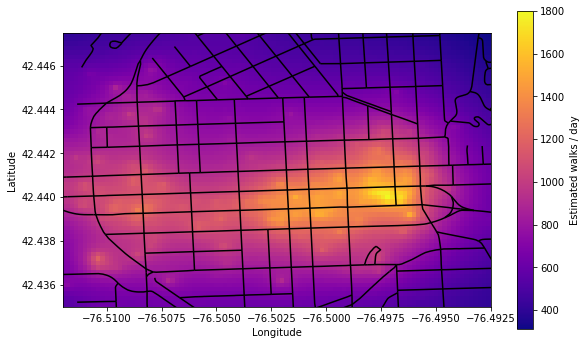

In [766]:
fig, ax = plt.subplots(figsize=(8.5,5))

pts.plot(column='tot_usage', cmap='plasma', legend=True, ax=ax,
        legend_kwds={'label': "Estimated walks / day"})
roads.plot(ax=ax, color='Black')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.xlabel('Longitude')
plt.ylabel('Latitude');
plt.tight_layout()
plt.savefig("figures/commons_usage.png", dpi=400)

Text(0.5, 602.2950463722055, 'Housing Parcels')

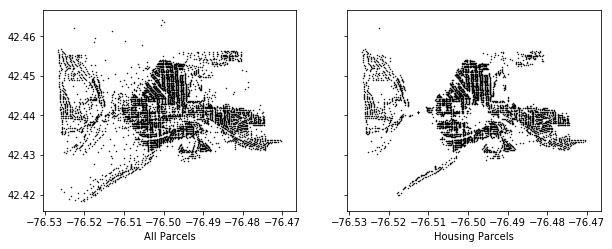

In [624]:
joined = joined.to_crs({'init': 'epsg:4269'})
housing = get_category('housing', joined)

fig, axs = plt.subplots(1, 2, sharey = True, figsize=(10, 20))

parcel_data.plot(marker=".", color="black", markersize=1, ax=axs[0])
housing.plot(marker=".", color="black", markersize=1, ax=axs[1])
axs[0].set_xlabel("All Parcels")
axs[1].set_xlabel("Housing Parcels")
# plt.gcf().set_size_inches(11,8)

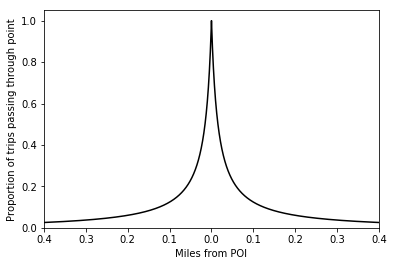

In [806]:
x = np.arange(-1, 1, 0.0001)
y = np.exp(-1 * np.abs(x)) / (1 + 20*np.pi*np.abs(x))
plt.plot(x, y, color='k')

plt.xlim(-.4, .4)
plt.ylim(0, None)
plt.ylabel("Proportion of trips passing through point")
plt.xlabel("Miles from POI")

ax = plt.gca()
ax.set_xticklabels([abs(x)/10 for x in range(-4,5)])

plt.savefig("figures/decay_function.png", dpi=400 )

In [805]:
np.arange(-.4, .5, .1)

array([-4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
       -1.11022302e-16,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
        4.00000000e-01])

In [770]:
xs

array([-76.512 , -76.5118, -76.5116, -76.5114, -76.5112, -76.511 ,
       -76.5108, -76.5106, -76.5104, -76.5102, -76.51  , -76.5098,
       -76.5096, -76.5094, -76.5092, -76.509 , -76.5088, -76.5086,
       -76.5084, -76.5082, -76.508 , -76.5078, -76.5076, -76.5074,
       -76.5072, -76.507 , -76.5068, -76.5066, -76.5064, -76.5062,
       -76.506 , -76.5058, -76.5056, -76.5054, -76.5052, -76.505 ,
       -76.5048, -76.5046, -76.5044, -76.5042, -76.504 , -76.5038,
       -76.5036, -76.5034, -76.5032, -76.503 , -76.5028, -76.5026,
       -76.5024, -76.5022, -76.502 , -76.5018, -76.5016, -76.5014,
       -76.5012, -76.501 , -76.5008, -76.5006, -76.5004, -76.5002,
       -76.5   , -76.4998, -76.4996, -76.4994, -76.4992, -76.499 ,
       -76.4988, -76.4986, -76.4984, -76.4982, -76.498 , -76.4978,
       -76.4976, -76.4974, -76.4972, -76.497 , -76.4968, -76.4966,
       -76.4964, -76.4962, -76.496 , -76.4958, -76.4956, -76.4954,
       -76.4952, -76.495 , -76.4948, -76.4946, -76.4944, -76.4